# K Nearest Neighbour algorithm
## Imports
Relevant imports for this algorithm

In [1]:
#https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from math import sqrt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

## Functions

In [2]:
def loadData():
    df = pd.read_csv('telecom_churn.csv')
    # Remove churn from X and put it in y
    X = df.drop("Churn",axis=1)
    y = df["Churn"]
    return df,X,y

### Split in data set, validation set and test set

In [3]:
def splitData(X, y, test_size, random_state):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y) #, stratify=y, 1
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=test_size, random_state=random_state, stratify=y_train_val) #, stratify=y_train_val, 1
    
    return X_train, X_val, X_test, y_train, y_val, y_test

### Resample of training data set

In [4]:
def resample_dataset(X_train, y_train, random_state):
    df_train = X_train.copy()
    df_train["Churn"]=y_train

    df_majority = df_train[df_train.Churn == 0]
    df_minority = df_train[df_train.Churn == 1]

    df_min_up = resample(df_minority, replace=True, n_samples=750, random_state=random_state) #750
    #print(df_minority.shape, df_majority.shape, df_min_up.shape)

    df_maj_up = resample(df_majority, replace=False, n_samples=1500, random_state=random_state)
    #print(df_minority.shape, df_majority.shape, df_maj_up.shape)

    df_up = pd.concat([df_min_up, df_maj_up])
    
    print("Counts after resample\n", df_up.Churn.value_counts())
    X_train = df_up.drop("Churn",axis=1)
    y_train = df_up["Churn"] 
    return X_train, y_train

### Scale data set

In [5]:
def scale(X_train, X_val, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    return X_train, X_val, X_test

### Classifier

In [6]:
def train_classifier(X_train, y_train, neighbors, metric):
    classifier = KNeighborsClassifier(n_neighbors=neighbors, metric=metric) #24
    classifier.fit(X_train, y_train)

    return classifier

### Cross validation

In [7]:
def cross_validation(classifier, X_val, y_val, scoring):
    classifier_cross_val = cross_val_score(classifier, X_val, y_val, scoring=scoring)
    print("\nCross_validation score: {:.2f}".format(classifier_cross_val.mean()))

### Best metric
train a classifier with each distance matric and find out which metric works best

In [8]:
def best_metric(metrics, X_train, y_train, X_val, y_val): #accuracy_score, precision_score, recall_score
    metric_best = None
    best_f1_score = 0 
    for metric in metrics:
        clf = train_classifier(X_train, y_train, 37, metric)
        y_pred = clf.predict(X_val)
        score = round(f1_score(y_val, y_pred), 4)
        recall = round(recall_score(y_val, y_pred), 4)
        precision = round(precision_score(y_val, y_pred), 4)
        accuracy = round(accuracy_score(y_val, y_pred), 4)
        print("Metric: ", metric, " F1 score: ", score, " Recall: ", recall, 
              " Precision: ", precision, " Accuracy: ", accuracy)
        if score > best_f1_score:
            metric_best = metric
            best_f1_score = score
        
    print("Best metric: ", metric_best)
    return metric_best

## Graphs
Visualizations as classification report, confusion matrix, and error graph

### Classification report and confusion matrix

In [9]:
def show_classification_report(y, y_pred):
    cf_matrix = confusion_matrix(y, y_pred)
#     print(cf_matrix)
    target_names = ['Not Churn', 'Churn']
    #Classification_report
    print("\nClassification report\n")
    print(classification_report(y, y_pred, target_names=target_names))

    #https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
    group_names = ["True Negative","False Positive","False Negative","True Positive"]
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    print("\nConfusion matrix")
    sns_plot = sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

### Error graph

In [10]:
def error_graph(X_train, y_train, X_val, y_val, metric):
    error = []

    # Calculating error for K values between 1 and 40
    for i in range(1, 40):
        knn = KNeighborsClassifier(n_neighbors=i, metric=metric)
        knn.fit(X_train, y_train)
        pred_i = knn.predict(X_val)
        error.append(np.mean(pred_i != y_val))
    neighbours = error.index(min(error))+1
    print("Neighbours with minimum error: ", neighbours)
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
             markerfacecolor='blue', markersize=10)
    plt.title('Error Rate K Value')
    plt.xlabel('K Value')
    plt.ylabel('Mean Error')
    return neighbours

In [11]:
def score_graph(X_val, y_val, metric):
    k_range = range(1, 31)
    k_f1_scores = []
    k_recall_scores = []
    # use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        f1_scores = cross_val_score(knn, X_val, y_val, cv=5, scoring='f1')
        recall_scores = cross_val_score(knn, X_val, y_val, cv=5, scoring='recall')
        k_f1_scores.append(f1_scores.mean())# plot to see clealy
        k_recall_scores.append(recall_scores.mean())# plot to see clealy

    plt.plot(k_range, k_f1_scores, marker='o')
    plt.plot(k_range, k_recall_scores, marker='o')
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.show()

    k_neighbor = k_f1_scores.index(max(k_f1_scores))+1
    print(k_neighbor)
    print(k_recall_scores.index(max(k_recall_scores))+1)

In [26]:
from sklearn.metrics import roc_curve, auc
from matplotlib.legend_handler import HandlerLine2D

def auc_score(x_train, y_train, x_test, y_test):
    neighbors = list(range(1,30))
    train_results = []
    test_results = []
    for n in neighbors:
        model = KNeighborsClassifier(n_neighbors=n)
        model.fit(x_train, y_train)
        train_pred = model.predict(x_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        y_pred = model.predict(x_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)


    line1, = plt.plot(neighbors, train_results, "b", label="Train AUC")
    line2, = plt.plot(neighbors, test_results, "r", label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel("AUC score")
    plt.xlabel("n_neighbors")
    plt.show()

## Train dataset

In [27]:
#Random_state and test_split
random_state = 1
test_split = 0.2

#Load data set
df, X, y = loadData()
#Split data set
X_train, X_val, X_test, y_train, y_val, y_test = splitData(X, y, test_split, random_state)
#Resample data set
X_train, y_train = resample_dataset(X_train, y_train, random_state)
#Scale data set
X_train, X_val, X_test = scale(X_train, X_val, X_test)

Counts after resample
 0    1500
1     750
Name: Churn, dtype: int64


In [28]:
# The metrics we are going to test with to find the best metric
metrics = ["euclidean", "manhattan", "minkowski", "chebyshev"]
#euclidean, manhattan, chebyshev, minkowski, wminkowski, seuclidean, mahalanobis

#Best metric
metric = best_metric(metrics, X_train, y_train, X_val, y_val) 

Metric:  euclidean  F1 score:  0.6622  Recall:  0.6364  Precision:  0.6901  Accuracy:  0.9064
Metric:  manhattan  F1 score:  0.6939  Recall:  0.6623  Precision:  0.7286  Accuracy:  0.9157
Metric:  minkowski  F1 score:  0.6622  Recall:  0.6364  Precision:  0.6901  Accuracy:  0.9064
Metric:  chebyshev  F1 score:  0.6242  Recall:  0.6364  Precision:  0.6125  Accuracy:  0.8895
Best metric:  manhattan


Neighbours with minimum error:  18


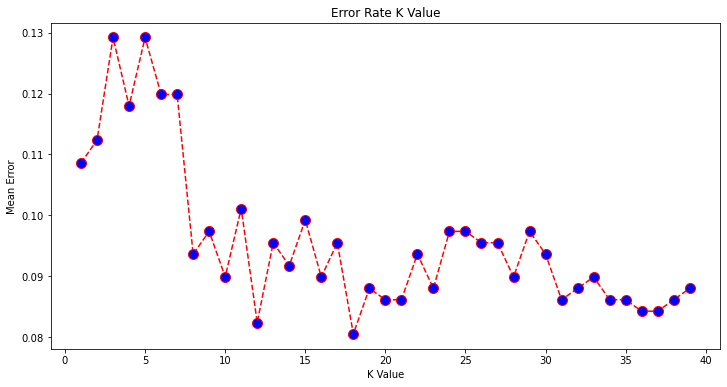

In [30]:
# find n: number of neighbours with minimum error rate
n = error_graph(X_train, y_train, X_val, y_val, metric)

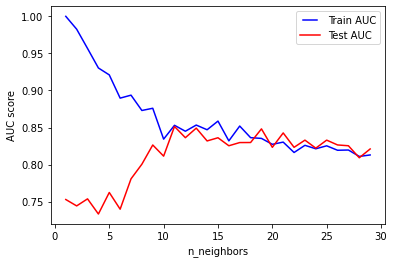

In [29]:
auc_score(X_train, y_train, X_val, y_val)

In [43]:
#Train classifier to find best K value
clf = train_classifier(X_train, y_train, n, metric)
#Cross validation score
cross_validation(clf, X_val, y_val, "accuracy")


Cross_validation score: 0.87



Classification report

              precision    recall  f1-score   support

   Not Churn       0.95      0.95      0.95       457
       Churn       0.72      0.71      0.72        77

    accuracy                           0.92       534
   macro avg       0.84      0.83      0.84       534
weighted avg       0.92      0.92      0.92       534


Confusion matrix


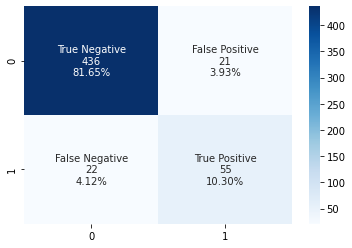

In [44]:
# Classification report
y_pred_val = clf.predict(X_val)
show_classification_report(y_val, y_pred_val)

# Test with test dataset


Classification report

              precision    recall  f1-score   support

   Not Churn       0.94      0.94      0.94       570
       Churn       0.64      0.62      0.63        97

    accuracy                           0.89       667
   macro avg       0.79      0.78      0.78       667
weighted avg       0.89      0.89      0.89       667


Confusion matrix


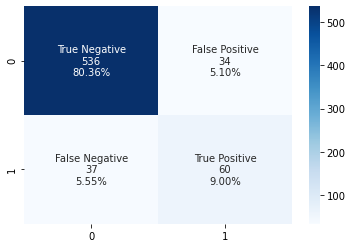

In [45]:
# Test with test values
clf = train_classifier(X_train, y_train, n, metric)
accuracy = clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
show_classification_report(y_test, y_pred)